<a href="https://colab.research.google.com/github/ez314/Fake-Reviews-Project/blob/main/GPT2_Control_Generation_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

gpt2 control generation in active development

Changes since v3:
- Generate CG/OR datasets
- Equalize ratings distribution

Future Work
- Categories
  - ~~Infer amazon category name from data~~ Done
  - Randomize order?
  - Prune products without categories?
- Model Robustness
  - ~~Pick an even distribution of ratings, to boost performance of less-common scores like 1.~~ Done, but it doesn't work that well?  
- QoL
  - ~~Use form fields for environment variables~~ Done
  - Seed randomness across the entire model using a global seed
  - Automatically model CG ratings distribution around the calculated OR ratings distribution
- Data Generation
  - Be able to generate review subjects alongside the body
  - ~~Build CG/OR dataset just like in paper 2~~ Done

In [ ]:
#@title Configuration Variables

#@markdown Workspace root folder
WORKSPACE = '/content/drive/MyDrive/College/Classes/CS 4v98/CS 4v98 Shared Data/Workspace' #@param {type: "string"}

#@markdown Category name be used in dataset URL replacement
CATEGORY_NAME_URL = 'Automotive' #@param {type: "string"}

#@markdown Category name to be used for save files
CATEGORY_NAME_SIMPLE = "Automotive" #@param {type: "string"}

#@markdown Language Model
MODEL = 'gpt2' #@param ['gpt2']

#@markdown Version to be used for save files
CODE_VER =  4#@param {type: "number"}
#@markdown ---

CODE_VER = f'v{CODE_VER}'

## Python and Env Configuration

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Pip install

In [ ]:
!pip install -q transformers sentencepiece
!pip install -q fastai --upgrade

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 33.4 MB/s 
     |████████████████████████████████| 6.5 MB 34.2 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 189 kB 5.4 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 


#### Python imports

In [ ]:
import os, gzip, json, gc, re, random
from collections import Counter, defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, AutoModelForPreTraining
from fastai.text.all import *

### Set environment and constants

In [ ]:
# Set environment variables
%set_env WORKSPACE $WORKSPACE
%set_env CATEGORY_NAME_URL $CATEGORY_NAME_URL
%set_env CATEGORY_NAME_SIMPLE $CATEGORY_NAME_SIMPLE

# Set python constants/configs
SPECIAL_TOKENS  = { "bos_token": "<|BOS|>",
                    "eos_token": "<|EOS|>",
                    "unk_token": "<|UNK|>",
                    "pad_token": "<|PAD|>",
                    "sep_token": "<|SEP|>"}

# Set dir to WORKSPACE
%cd {WORKSPACE}

env: WORKSPACE=/content/drive/MyDrive/College/Classes/CS 4v98/CS 4v98 Shared Data/Workspace
env: CATEGORY_NAME_URL=Automotive
env: CATEGORY_NAME_SIMPLE=Automotive
/content/drive/MyDrive/College/Classes/CS 4v98/CS 4v98 Shared Data/Workspace


## Load Data

### [Skip after first time] Fetch data from source, process, and save

#### Download and extract data

In [ ]:
%%bash

download_and_extract() {
  local filename=`basename "$1"`
  local filename_ex=${filename%.gz}

  # Extract file if json not there
  if [ ! -f "$filename_ex" ]
  then
    # Download original file if not there
    if [ ! -f "$filename" ]
    then
      echo "Downloading $filename"
      wget -q "$1"
    fi
    echo "Extracting to $filename_ex"
    gzip -d "$filename"
  else
    echo "Nothing to do: $filename_ex already exists"
  fi
}

download_and_extract "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/"$CATEGORY_NAME_URL".json.gz"
download_and_extract "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_"$CATEGORY_NAME_URL".json.gz"

Extracting to Automotive.json
Extracting to meta_Automotive.json


#### Load all metadata into memory

In [ ]:
%%time

# Load unzpped metadata into memory
metadata = {}
useless_categories = None
with open(f'meta_{CATEGORY_NAME_URL}.json') as f:
  counter = 0
  for l in f:
    counter += 1
    if counter % 100000 == 0:
      print(f'Loading item number {counter}')
    j = json.loads(l.strip())

    # Ensure category is list of str
    # if type(j['category']) is not list or any(type(x) is not str for x in j['category']):
    #   print('uh oh!', j)

    # Remove any surrounding spaces from the category
    category = [x.strip() for x in j['category']]

    # Only load fields you will use! Otherwise, memory usage is extremely high.
    metadata[j['asin']] = {
        'title': j['title'],
        'category': category
    }

    # Track useless categories
    if category: 
      if useless_categories is None:
        useless_categories = set(category)
      else:
        useless_categories = useless_categories & set(category)

# Convert categories to string, after removing any useless ones
if useless_categories is None:
  useless_categories = set()
for m in metadata.values():
  m['category'] = ','.join(filter(lambda x: x not in useless_categories, m['category']))

# total length of list, this number equals total number of products
print(f'Loaded {len(metadata)} items')
print(f'Pruned useless categories: {", ".join(useless_categories)}')


Loading item number 100000
Loading item number 200000
Loading item number 300000
Loading item number 400000
Loading item number 500000
Loading item number 600000
Loading item number 700000
Loading item number 800000
Loading item number 900000
Loaded 924693 items
Pruned useless categories: Automotive
CPU times: user 2min 59s, sys: 25 s, total: 3min 24s
Wall time: 3min 55s


#### Load all reviews into memory

In [ ]:
%%time

NUM_REVIEWS_PER_RATING = 40000

# Keep track of which product ASINs we haven't looked at. These are guaranteed to not appear in training data
unseen_asins = set(metadata.keys())

# Build training data and store to reviews (defaultdict of rating -> list(review))
reviews = defaultdict(list)
with open(f'{CATEGORY_NAME_URL}.json') as f:
  i = 0
  for l in f:
    j = json.loads(l.strip())

    # Filter unusable reviews
    if 'summary' not in j or 'reviewText' not in j or j['asin'] not in metadata:
      continue

    # Increment counter, break if loaded enough reviews, print progress
    i += 1
    # if i > 1000000:
    #   break
    if i % 500000 == 0:
      print(f'Loading review number {i}')


    # Build string with control codes & review
    prod_meta = metadata[j['asin']]
    rating = str(int(j["overall"]))

    if len(reviews[rating]) < NUM_REVIEWS_PER_RATING:
      reviews[rating].append(
          SPECIAL_TOKENS['bos_token'] + prod_meta['title'] + \
          SPECIAL_TOKENS['sep_token'] + prod_meta['category'] + \
          SPECIAL_TOKENS['sep_token'] + rating + \
          SPECIAL_TOKENS['sep_token'] + j['reviewText'] + \
          SPECIAL_TOKENS['eos_token']
      )

      # Track unseen ASINs
      if j['asin'] in unseen_asins:
        unseen_asins.remove(j['asin'])

all_reviews = []
for rating in reviews:
  print(f'{len(reviews[rating])} reviews with rating of {rating}.')
  for review in reviews[rating]: #np.random.choice(reviews[rating], 15000, replace=False):
    all_reviews.append((review))


all_reviews = pd.DataFrame(all_reviews, columns=["reviewText"])
all_reviews.to_csv(f'{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}.csv', index=False)

Loading review number 500000
Loading review number 1000000
Loading review number 1500000
Loading review number 2000000
Loading review number 2500000
Loading review number 3000000
Loading review number 3500000
Loading review number 4000000
Loading review number 4500000
Loading review number 5000000
Loading review number 5500000
Loading review number 6000000
Loading review number 6500000
Loading review number 7000000
Loading review number 7500000
40000 reviews with rating of 5.
40000 reviews with rating of 3.
40000 reviews with rating of 1.
40000 reviews with rating of 4.
40000 reviews with rating of 2.
CPU times: user 1min 6s, sys: 3.06 s, total: 1min 9s
Wall time: 1min 21s


#### Manual inspection

In [ ]:
all_reviews.head() # Make sure the data looks right

,reviewText
0,<|BOS|>Lightwedge Paperback - Black<|SEP|>Lighting & Ceiling Fans<|SEP|>3<|SEP|>I received the book lightwedge but have not used it as of yet so I cannot give a rating<|EOS|>
1,"<|BOS|>Breeding Organic Vegetables: A Step-by-Step Guide for Growers<|SEP|>Rough Plumbing,Water Heaters & Parts<|SEP|>3<|SEP|>I cannot get water more than luke warm, even at a low flow rate,.<|EOS|>"
2,"<|BOS|>Breeding Organic Vegetables: A Step-by-Step Guide for Growers<|SEP|>Rough Plumbing,Water Heaters & Parts<|SEP|>3<|SEP|>If I were married, I'd be in trouble for buying this. I live halfway down in texas and it's barely adequate during summer when I need to shower. Replaced a 30 gallon water heater in a house with 2 water heaters, I live alone. It's not that cold here in winter but waiting to see if it'll be enough. Puts out just enough hot water in the summer, but I'm afraid if it's cold in the house in the winter the small volume of hot water it produces is going to make for one col..."
3,"<|BOS|>Breeding Organic Vegetables: A Step-by-Step Guide for Growers<|SEP|>Rough Plumbing,Water Heaters & Parts<|SEP|>3<|SEP|>I purchased Model IR-260 on-line, which seemed to be a good fit for my pool house served by a well (Texas). I had difficulty getting the various fittings to align with the installed plumbing; the local hardware and plumbing stores could not figure it out, either. I called SioGreen and spoke with Iris (who had a defective headset and was, therefore, very difficult to communicate with). She had an engineer, Anthony, return my call. He informed me that this model wa..."
4,"<|BOS|>Breeding Organic Vegetables: A Step-by-Step Guide for Growers<|SEP|>Rough Plumbing,Water Heaters & Parts<|SEP|>3<|SEP|>I am having difficulty with it.<|EOS|>"


Rating dist: {1.0: 817515, 2.0: 413875, 3.0: 611394, 4.0: 1301947, 5.0: 5870472}


#### Build prompts from unseen ASINs set

In [ ]:
%%time

# Convert unseen asin set to prompts df
prompts = {}
for i, asin in enumerate(unseen_asins, 1):
  prod_meta = metadata[asin]
  prompts[i] = SPECIAL_TOKENS['bos_token'] + prod_meta['title'] + \
                SPECIAL_TOKENS['sep_token'] + prod_meta['category'] + \
                SPECIAL_TOKENS['sep_token'] + '5' + \
                SPECIAL_TOKENS['sep_token']

print(f'There are {len(prompts)} prompts available to test with')

prompts = pd.DataFrame.from_dict(prompts, columns=["prompt"], orient="index")
prompts.to_csv(f"{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}_prompts.csv", index=False)

There are 911819 prompts available to test with
CPU times: user 6.13 s, sys: 364 ms, total: 6.49 s
Wall time: 7.05 s


In [ ]:
prompts.head()

,prompt
1,"<|BOS|>Panel Mount Battery Gauge for Dual Batteries - Panther<|SEP|>Replacement Parts,Batteries & Accessories<|SEP|>5<|SEP|>"
2,"<|BOS|>Monroe 72293 OESpectrum Premium Strut<|SEP|>Replacement Parts,Shocks, Struts & Suspension,Shocks & Struts,Struts<|SEP|>5<|SEP|>"
3,"<|BOS|>Fit 2008-2011 Cadillac CTS Front Sport Drill Slot Brake Rotors+Ceramic Brake Pad<|SEP|>Replacement Parts,Brake System,Brake Kits<|SEP|>5<|SEP|>"
4,"<|BOS|>Lisle 64870 Back Probe, Red, 90-Degree<|SEP|>Tools & Equipment,Electrical System Tools<|SEP|>5<|SEP|>"
5,"<|BOS|>PODOY Camper White 1156 5050 BA15S SMD 18 LED Tail Bulbs for RV Camper SUV MPV Car (2 Pack)<|SEP|>Replacement Parts,Switches & Relays,Relays<|SEP|>5<|SEP|>"


#### Garbage Collect

In [ ]:
# Save memory, clear useless large objects no longer used after this section
del metadata
del unseen_asins
del reviews
gc.collect()

167

### [Only run after first time] Load processed data from disk

In [ ]:
all_reviews = pd.read_csv(f"{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}.csv", sep=",")
prompts = pd.read_csv(f"{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}_prompts.csv", sep=",")

### Break data into train and valid

In [ ]:
sample_df = all_reviews

In [ ]:
#sample_df = all_reviews.sample(n=50000, random_state=2021).dropna().reset_index()

In [ ]:
del all_reviews
gc.collect()

177

In [ ]:
df_train, df_valid = train_test_split(sample_df, random_state=2021, test_size=0.1)
all_texts = np.concatenate([df_train["reviewText"].values, df_valid["reviewText"].values])

## Download Pre-Trained Model (gpt2)
And configure tokenizer to recognize special tokens


In [ ]:
def get_tokenizer(special_tokens=None):
    tokenizer = AutoTokenizer.from_pretrained(MODEL) #GPT2Tokenizer

    if special_tokens:
        tokenizer.add_special_tokens(special_tokens)
        print("Special tokens added")
    return tokenizer

def get_model(tokenizer, special_tokens=None, load_model_path=None):

    #GPT2LMHeadModel
    if special_tokens:
        config = AutoConfig.from_pretrained(MODEL, 
                                            bos_token_id=tokenizer.bos_token_id,
                                            eos_token_id=tokenizer.eos_token_id,
                                            sep_token_id=tokenizer.sep_token_id,
                                            pad_token_id=tokenizer.pad_token_id,
                                            output_hidden_states=False)
    else: 
        config = AutoConfig.from_pretrained(MODEL,                                     
                                            pad_token_id=tokenizer.eos_token_id,
                                            output_hidden_states=False)    

    model = AutoModelForPreTraining.from_pretrained(MODEL, config=config)

    if special_tokens:
        #Special tokens added, model needs to be resized accordingly
        model.resize_token_embeddings(len(tokenizer))

    if load_model_path:
        model.load_state_dict(torch.load(load_model_path))

    model.cuda()
    return model

In [ ]:
tokenizer = get_tokenizer(SPECIAL_TOKENS)
model = get_model(tokenizer, special_tokens=SPECIAL_TOKENS)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens added


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)[:1024]
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
splits = [list(df_train.index), list(df_valid.index)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [ ]:
tls.train[0]

tensor([50257,  5990,  9830,    87,   807,  1485,  3559, 12297,    12,  4653,
         1096,   406, 29812,   415,    11,   352, 15649,    13, 34510, 50261,
           46,  4487,  1222,   696,    26, 34070,  2340,    11, 43887,  1386,
         1222,   696,    26,   406, 29812,  1187,    11,    43, 29812,  1187,
           11, 28795,    12,  4653,  1096, 50261,    19, 50261,  1212,   318,
          257, 23754, 10474,   300,  3266,    13,   220,   383,  5876,   318,
          326,   262,  3098,    12,   325,  1096,  7515,   318,   845,  1327,
          284,   651,   572,  2832,    11,  8242,    11,   262,  4314,  1377,
         1997,   340, 18105,    13,   220,  1002,   345,   389,   257,   497,
          729,  8383,   621,   314,   716,    11,   428,  1839,   470,   307,
          257,  1263, 43585,    13, 50258])

In [ ]:
tls.valid[0]

tensor([50257,    57,   272,  2256, 31763,   370, 21870,    44, 16562,  3169,
          404, 25924,  6462, 15399, 18007,    11,  2619, 50261, 34919, 13696,
         1222, 20668,  3742,    11, 19703, 13967, 10740,    11,    49,  2530,
         7123, 13927,    11, 32388,   337,  6791, 50261,    17, 50261,  1532,
          345,   423,   257,  1588, 30777,   836,   470,  2822,    11,   663,
          925,   329,  1310,   661, 47226, 50258])

In [ ]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([105]), torch.Size([56]))

In [ ]:
show_at(tls.train, 0)

<|BOS|>Permatex 81343 Anti-Seize Lubricant, 1 oz. Tube<|SEP|>Oils &amp; Fluids,Greases &amp; Lubricants,Lubricants,Anti-Seize<|SEP|>4<|SEP|>This is a terrific assembly lube.  The trouble is that the anti-seize component is very hard to get off hands, clothes, the floor -- anything it touches.  If you are a neater worker than I am, this won't be a big drawback.<|EOS|>


In [ ]:
show_at(tls.valid, 0)

<|BOS|>Zanheadgear WNFM114 Neoprene Full Face Mask, Black<|SEP|>Motorcycle & Powersports,Protective Gear,Riding Headwear,Face Masks<|SEP|>2<|SEP|>If you have a large grape don't buy, its made for little people :-)<|EOS|>


In [ ]:
%%time

bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1309 > 1024). Running this sequence through the model will result in indexing errors


CPU times: user 2min 11s, sys: 542 ms, total: 2min 12s
Wall time: 2min 13s


In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"<|BOS|>Meguiar's G10307 ScratchX 2.0 - 7 oz. &ndash; Safe Scratch and Swirl Remover<|SEP|>Car Care,Exterior Care,Car Wash Equipment<|SEP|>1<|SEP|>It didn't work for my black Acura. Scratches are still there even after I followed the instructions.<|EOS|><|BOS|>Goldenrod 505 Spring Bottom Oiler with Straight Spout - 6 oz. Capacity<|SEP|>Tools & Equipment,Garage & Shop,Fuel Transfer & Lubrication,Oil Lube Systems<|SEP|>1<|SEP|>Filled it with oil and screwed on the top. Noticed oil on the bench. Dripping from the base seam. Unusable.<|EOS|><|BOS|>Sheepskin Stretch-On Steering Wheel Cover-Grey<|SEP|>Interior Accessories,Steering Wheels & Accessories,Steering Accessories<|SEP|>2<|SEP|>The sheepskin is a bit skimpy and the color came off on my hands.<|EOS|><|BOS|>Schumacher PS-400-3A Instant Power Jump Starter<|SEP|>Tools & Equipment,Jump Starters, Battery Chargers & Portable Power,Jump Starters<|SEP|>1<|SEP|>I used this item for a gift, and was embarrassed when the recipitant found it broken in several places. He was able to exchange at a local business who","Meguiar's G10307 ScratchX 2.0 - 7 oz. &ndash; Safe Scratch and Swirl Remover<|SEP|>Car Care,Exterior Care,Car Wash Equipment<|SEP|>1<|SEP|>It didn't work for my black Acura. Scratches are still there even after I followed the instructions.<|EOS|><|BOS|>Goldenrod 505 Spring Bottom Oiler with Straight Spout - 6 oz. Capacity<|SEP|>Tools & Equipment,Garage & Shop,Fuel Transfer & Lubrication,Oil Lube Systems<|SEP|>1<|SEP|>Filled it with oil and screwed on the top. Noticed oil on the bench. Dripping from the base seam. Unusable.<|EOS|><|BOS|>Sheepskin Stretch-On Steering Wheel Cover-Grey<|SEP|>Interior Accessories,Steering Wheels & Accessories,Steering Accessories<|SEP|>2<|SEP|>The sheepskin is a bit skimpy and the color came off on my hands.<|EOS|><|BOS|>Schumacher PS-400-3A Instant Power Jump Starter<|SEP|>Tools & Equipment,Jump Starters, Battery Chargers & Portable Power,Jump Starters<|SEP|>1<|SEP|>I used this item for a gift, and was embarrassed when the recipitant found it broken in several places. He was able to exchange at a local business who carried"
1,"It states that this is about 260mm while the 120.40057 rotor has a diameter of 300mm. Hope this helps!<|EOS|><|BOS|>Meguiar's G14422 Ultimate Quik Detailer - 22 oz. &ndash; Premium Spray Detailer<|SEP|>Car Care,Tools & Equipment,Detailing Tools<|SEP|>2<|SEP|>I like Meguiars other products but not this.\nFollowed directions correctly. Because there was mild invisible debris on my car using this and wiping down just left tiny scratches on my car<|EOS|><|BOS|>Hopkins 08525 Graduated Level<|SEP|>Tools &amp; Equipment<|SEP|>2<|SEP|>I give it a lower grade because after a short 4 months the nice green liquid inside the bubble turned clear, making it more difficult to see. Had 2 installed both turned clear. With no explanation of why. One was placed in front other on side and both turned clear, wondered if anyone else have done the same or did I get a bad set?<|EOS|><|BOS|>Lisle 30800 CV Boot Clamp Pliers<|SEP|>Motorcycle & Powersports,Parts,Drive Train,CV Boots & Joints<|SEP|>3<|SEP|>Used it on one job","states that this is about 260mm while the 120.40057 rotor has a diameter of 300mm. Hope this helps!<|EOS|><|BOS|>Meguiar's G14422 Ultimate Quik Detailer - 22 oz. &ndash; Premium Spray Detailer<|SEP|>Car Care,Tools & Equipment,Detailing Tools<|SEP|>2<|SEP|>I like Meguiars other products but not this.\nFollowed directions correctly. Because there was mild invisible debris on my car using this and wiping down just left tiny scratches on my car<|EOS|><|BOS|>Hopkins 08525 Graduated Level<|SEP|>Tools &amp; Equipment<|SEP|>2<|SEP|>I give it a lower grade because after a short 4 months the nice green liquid inside the bubble turned clear, making it more difficult to see. Had 2 installed both turned clear. With no explanation of why. One was placed in front other on side and both turned clear, wondered if anyone else have don

## Fine-tuning

### Create Learner from model

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

### [Skip after first time] Run fine-tuning and save

In [ ]:
learn.validate()

(#2) [93.18417358398438,inf]

CPU times: user 20.1 s, sys: 1.36 s, total: 21.5 s
Wall time: 23.8 s


SuggestedLRs(valley=0.0002754228771664202)

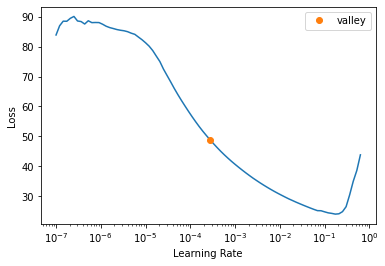

In [ ]:
%%time
learn.lr_find()

In [ ]:
%%time
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,2.295566,2.204673,9.067288,56:56


CPU times: user 55min 31s, sys: 1min 13s, total: 56min 45s
Wall time: 56min 56s


In [ ]:
learn.save(f"gpt2-control-generation-{CATEGORY_NAME_SIMPLE}-{CODE_VER}")

Path('models/gpt2-control-generation-Automotive-v4.pth')

### [Only run after first time] Load fine-tuned model from disk

In [ ]:
learn.load(f"gpt2-control-generation-{CATEGORY_NAME_SIMPLE}-{CODE_VER}")

## Run Model

### Manual Checking

In [ ]:
prompts.head(10) # Display some products that we haven't trained on

,prompt
0,"<|BOS|>Espresso Wenge Reversible L-Desk 72&quot;W with Brushed Nickel Modesty Panel Legs - At Work Collection<|SEP|>Office Furniture & Lighting,Desks & Workstations,Desks,Office Desks<|SEP|>5<|SEP|>"
1,"<|BOS|>STEELMASTER Contemporary Vertical Organizer with 4 Slots, 8.38 x 12 x 7.25 Inches, Granite (2644500A3)<|SEP|>Office Furniture & Lighting,Cabinets, Racks & Shelves,Racks & Displays<|SEP|>5<|SEP|>"
2,"<|BOS|>100 5x7 Reclosable Poly Clear Plastic Zip Lock Zipper Bag 4 Mil Jewelry Baggies<|SEP|>Office & School Supplies,Envelopes, Mailers & Shipping Supplies,Mail Bags & Transit Sacks,Mail Bags<|SEP|>5<|SEP|>"
3,<|BOS|>GLOBE-WEIS Colored Classification Folder (PU5615LBL)<|SEP|>Office & School Supplies<|SEP|>5<|SEP|>
4,"<|BOS|>3&quot; X 4&quot; - 2 Mil Clear White Block Reclosable Poly Zip Lock Bags Pack of 100<|SEP|>Office & School Supplies,Envelopes, Mailers & Shipping Supplies,Mail Bags & Transit Sacks,Mail Bags<|SEP|>5<|SEP|>"
5,"<|BOS|>Assorted Hand made Voodoo String Doll Key Chain (12 pieces)<|SEP|>Office & School Supplies,Forms, Recordkeeping & Money Handling,Key Tags & Chains<|SEP|>5<|SEP|>"
6,"<|BOS|>Vonage Phone Solution Adapter + Cordless Phone System, New for 2011 Vonage Digital Phone System Adapter and Dect 6.0 Motorola Cordless System L603 (not the previous L403) in One Box<|SEP|>Office Electronics,Telephones & Accessories,Landline Phones,Cordless Telephones<|SEP|>5<|SEP|>"
7,"<|BOS|>NEW 100 Feet Flexible Magnet Magnetic Strip 1&quot; wide Adhesive Back 30 Mil<|SEP|>Office & School Supplies,Tape, Adhesives & Fasteners,Interlocking Tape & Mounting Products,Magnetic Tape<|SEP|>5<|SEP|>"
8,"<|BOS|>Palmetto 2-Drawer Oak File Cabinet Warm Honey<|SEP|>Office & School Supplies,Forms, Recordkeeping & Money Handling,Key Cabinets, Racks & Holders,Cabinets<|SEP|>5<|SEP|>"
9,"<|BOS|>Pelikan Pelikano Blue Fountain Pen Medium<|SEP|>Office & School Supplies,Writing & Correction Supplies,Pens & Refills,Fountain Pens<|SEP|>5<|SEP|>"


In [ ]:
prompt = "<|BOS|>Espresso Wenge Reversible L-Desk 72&quot;W with Brushed Nickel Modesty Panel Legs - At Work Collection<|SEP|>Office Furniture & Lighting,Desks & Workstations,Desks,Office Desks<|SEP|>1<|SEP|>"
prompt_len = len(re.sub(r'<\|[A-Z]{3}\|>', '', prompt))

prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()

preds = learn.model.generate(inp, max_length=1024, do_sample=True, top_k=0, top_p=0.92, num_return_sequences=25, temperature=0.7)
for i, pred in enumerate(preds):
  print("{}: {}".format(i+1, tokenizer.decode(pred, skip_special_tokens=True)[prompt_len:]))

1: The legs are a bit too wide for my liking.  I got the drawer on the first floor and they are definitely not a good fit.  I am going to go back to the office supply store.  I will definitely buy again.
2: It is a HUGE piece of furniture.  It is a huge piece of junk.  It was just not worth the $30 it was charged for.  It is not worth the money.
3: The leg is too short, the hinge too tight, the hinge too loose, and the legs don't stay together.  My desk looks like it was scratched.  I'll never buy another one.
4: I had to use a hard to find regular staple tray to put in my desk, but it worked fine.  I didn't expect it to work.  I had to purchase a new one because I don't want to pay the extra $60 for a regular staple tray.  I also had to use a new staple tray because it was too heavy for my desk.  It was a total waste of money.
5: I have had this for over a year now and it has completely destroyed my desk.  The carpet is carpet, not even a single rug.  I am very happy with it.  It is n

### Generate CG/OG survey data

In [ ]:
%%time

# TODO: move these to top config
NUM_OR = 200
NUM_CG = 200

NUM_RET_SEQS = 1

mixed_reviews = [] # [product name, categories, star rating, CG/OG, review text]

regex_or = re.compile(r'<\|BOS\|>(.*)<\|SEP\|>(.*)<\|SEP\|>(\d)<\|SEP\|>(.*)<\|EOS\|>', re.MULTILINE | re.DOTALL)
regex_cg_prompt = re.compile(r'<\|BOS\|>(.*)<\|SEP\|>(.*)<\|SEP\|>\d<\|SEP\|>', re.MULTILINE | re.DOTALL)

# Add the OG data (which we trained on)
for review in np.random.choice(all_texts, NUM_OR, replace=False):
  if not regex_or.match(review):
    print(review)
  title, category, overall, reviewText = regex_or.match(review).groups()
  mixed_reviews.append([title, category, overall, 'OR', reviewText])

# Add the CG data
for prompt in np.random.choice(prompts['prompt'].values, NUM_CG, replace=False):
  title, category = regex_cg_prompt.match(prompt).groups()
  # overall = np.random.choice(list('12345'), p=[0.09, 0.05, 0.07, 0.14, 0.65]) # pick according to real distribution
  overall = str(random.randint(1, 5)) # pick star rating with equal probability
  prompt = SPECIAL_TOKENS['bos_token'] + title + \
                SPECIAL_TOKENS['sep_token'] + category + \
                SPECIAL_TOKENS['sep_token'] + overall + \
                SPECIAL_TOKENS['sep_token']
  
  # Generate NUM_RET_SEQS possible reviews
  prompt_len = len(re.sub(r'<\|[A-Z]{3}\|>', '', prompt))
  prompt_ids = tokenizer.encode(prompt)
  inp = tensor(prompt_ids)[None].cuda()
  preds = learn.model.generate(inp, max_length=1024, do_sample=True, top_k=0, top_p=0.92, num_return_sequences=NUM_RET_SEQS, temperature=0.7)

  # Pick one and add it to the mixed dataset
  idx = random.randrange(NUM_RET_SEQS)
  reviewText = tokenizer.decode(preds[idx], skip_special_tokens=True)[prompt_len:]
  mixed_reviews.append([title, category, overall, 'CG', reviewText])

mixed_reviews = pd.DataFrame(mixed_reviews, columns=["product", "category", "rating", "label", "review"])
mixed_reviews.to_csv(f'{CATEGORY_NAME_SIMPLE}_mixed_reviews_{CODE_VER}.csv', index=None)


CPU times: user 4min 23s, sys: 944 ms, total: 4min 24s
Wall time: 4min 28s


In [ ]:
mixed_reviews.head(20)

# Misc

## Find out what GPU is being used

GPU | Time to fine tune
-|-
T4 | 20  
K80 | 85

In [1]:
!nvidia-smi

Wed Mar  2 21:02:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

test